# **FinSights**
## 📘 GenAI-Powered Financial Assistant
Welcome to your AI-driven personal finance assistant! This notebook demonstrates how to transform raw bank statements (PDFs) into smart financial insights using Google’s Generative AI APIs. Analyze your bank statement with AI-powered insights, budget planning, and personalized financial health scoring. The final product is a RAG-powered chatbot that answers natural language questions about your spending during a given statement period.

### 📌 Problem Statement:
Manual budget analysis is time-consuming and inaccessible to most users.
People receive monthly bank statements but rarely understand them fully or act on insights. Traditional financial apps offer raw data but lack reasoning and personal feedback.

### 📊 Project Overview: Our Solution
This project uses Generative AI (Gemini) to:

- Parse real bank statements (PDF)
- Generate monthly summaries and structured transactions
- Create a monthly spending knowledge base
- Enable Q&A chat over personal financial data using RAG
- Support interactive evaluation of spending vs budget

### 🛠️ Setup
Install and configure Gemini.

## **Setup & Gemini Configuration**

In [2]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [3]:
import google.generativeai as genai
from google.genai import types

genai.__version__


'0.8.4'

In [23]:
for model in genai.list_models():
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
mod

### Set up your API key
To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.
If you don't already have an API key, you can grab one from AI Studio. 

In [150]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

genai.configure(api_key=GOOGLE_API_KEY)

In [161]:
# check whether the api works
model = genai.GenerativeModel("gemini-1.5-pro-latest")
response = model.generate_content("Hello Gemini! Can you summarize my March spending based on a bank statement?")
print(response.text)

Please share your bank statement with me! I'll do my best to summarize your March spending.  I can look for things like:

* **Total spent:** The overall amount you spent in March.
* **Spending by category:**  e.g., groceries, dining, entertainment, bills, etc.  (I'll need clear descriptions in your statement to categorize effectively.)
* **Largest expenses:**  Highlighting any particularly significant purchases.
* **Income vs. spending:** If your statement shows deposits, I can compare your income to your outgoings.

To protect your privacy, **please remove any personally identifiable information** such as your account number, full address, and any other details you're not comfortable sharing.  You can copy and paste the relevant transactions, or take a screenshot (making sure to block out sensitive info).



## **PDF Upload and Transaction Extraction**
We allow users to upload their monthly bank statement (PDF) and use Gemini to extract all relevant transactions.

In [8]:
#importing libraries to support pdf docs
!pip install -q pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 59.7 MB/s eta 0:00:00:00:0100:01


In [9]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# Update this to your uploaded file name
pdf_path = "/kaggle/input/statement/eStmt.pdf"
raw_text = extract_text_from_pdf(pdf_path)

print(raw_text[:1000])  # Preview first 1000 characters


Customer service information
Customer service: 1.800.432.1000
En Español: 1.800.688.6086
bankofamerica.com
Bank of America, N.A.
P.O. Box 25118
Tampa, FL 33622-5118
KRITHIKA JAIN
9425 ROUTE 29
FAIRFAX, VA  22031-1802
P.O. Box 15284
Wilmington, DE 19850
 PULL: B   CYCLE: 15   SPEC: E   DELIVERY: E   TYPE:    IMAGE: I   BC: VA
Page 1 of 6
Your Adv SafeBalance Banking 
for February 22, 2025 to March 24, 2025
Account number: 4350 5902 1281
KRITHIKA JAIN          
Account summary
Beginning balance on February 22, 2025
$492.56
Deposits and other additions
986.54
ATM and debit card subtractions
-11.00
Other subtractions
-873.25
Service fees
-0.00
Ending balance on March 24, 2025
$594.85
Take control of your retirement journey with Merrill
Visit merrilledge.com/invest to learn more.
Investing in securities involves risk, and there is always potential of losing money when you
invest in securities.
Merrill Lynch, Pierce, Fenner & Smith Incorporated ("MLPF&S" or "Merrill") makes available certain

## **Prompting Strategy: Few-shot**
**Structured output/JSON mode/controlled generation**

In [80]:
import json

# Step 1: Configure Gemini with correct model
model = genai.GenerativeModel(model_name="models/gemini-1.5-pro-latest")

# Step 2: Build the prompt using raw text or extracted candidate lines
prompt = f"""
You're a financial assistant. From the bank statement text below, extract all **financial transactions** in JSON format.

Each transaction must include:
- "date" (MM/DD/YY)
- "description"
- "amount" (float)
- "category" (infer based on description)

### Example Format:
[
  {{
    "date": "01/15/25",
    "description": "Starbucks Coffee",
    "amount": 5.65,
    "category": "Food & Drinks"
  }},
  ...
]

### Statement Text:
\"\"\"
{raw_text}
\"\"\"
"""

# Step 3: Send to Gemini
response = model.generate_content(prompt)
parsed_text = response.text.strip()
print(parsed_text)


```json
[
  {
    "date": "02/24/25",
    "description": "Zelle payment from MITANSHU SANKHE Conf# p78kcuz2l",
    "amount": 2.18,
    "category": "Transfer"
  },
  {
    "date": "02/25/25",
    "description": "Zelle payment from RESHMI ANANTAPALLI for \"SECURITY DEPOSIT RETURN\"; Conf# T0YKJZPC8",
    "amount": 42.85,
    "category": "Transfer"
  },
  {
    "date": "02/28/25",
    "description": "GEORGE MASON UNI DES:PAYROLL ID:XXXXXXXXX INDN:KRITHIKA JAIN CO ID:2540836354 PPD",
    "amount": 177.63,
    "category": "Payroll"
  },
  {
    "date": "03/03/25",
    "description": "Zelle payment from JYOTHIKA JAIN Conf# 99azyeqig",
    "amount": 500.00,
    "category": "Transfer"
  },
  {
    "date": "03/14/25",
    "description": "GEORGE MASON UNI DES:PAYROLL ID:XXXXXXXXX INDN:KRITHIKA JAIN CO ID:2540836354 PPD",
    "amount": 263.88,
    "category": "Payroll"
  },
  {
    "date": "03/20/25",
    "description": "PURCHASE 0319 SMARTRIP WASHINGTON DC WASHINGTON DC",
    "amount": -11.00,
 

### Created a dataframe from json

In [86]:
# Remove markdown formatting if exists
if parsed_text.startswith("```json"):
    parsed_text = parsed_text.replace("```json", "").replace("```", "").strip()

# Now parse safely
import json
parsed_data = json.loads(parsed_text)

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(parsed_data)
df.head()


,date,description,amount,category
0,02/24/25,Zelle payment from MITANSHU SANKHE Conf# p78kc...,2.18,Transfer
1,02/25/25,"Zelle payment from RESHMI ANANTAPALLI for ""SEC...",42.85,Transfer
2,02/28/25,GEORGE MASON UNI DES:PAYROLL ID:XXXXXXXXX INDN...,177.63,Payroll
3,03/03/25,Zelle payment from JYOTHIKA JAIN Conf# 99azyeqig,500.00,Transfer
4,03/14/25,GEORGE MASON UNI DES:PAYROLL ID:XXXXXXXXX INDN...,263.88,Payroll


### Categorizing the expenditures based on the statement

In [144]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%y", errors="coerce")
df = df[(df["date"] >= statement_start) & (df["date"] <= statement_end)]
df["month"] = df["date"].dt.to_period("M").astype(str)
# Group by month and category
monthly_summary = (
    df.groupby(["month", "category"])["amount"]
    .sum()
    .reset_index()
    .sort_values(by="month")
)

monthly_summary.head()


,month,category,amount
0,2025-02,Payroll,177.63
1,2025-02,Transfer,32.45
2,2025-03,Food & Drinks,-103.93
3,2025-03,Payment,-100.48
4,2025-03,Payroll,263.88


## Function calling with the Gemini API for Monthly Spending Summary

In [154]:
def generate_monthly_spending_summary(df, statement_start, statement_end, statement_range=None):
    # Step 1: Clean & filter by statement period
    df["date"] = pd.to_datetime(df["date"], format="%m/%d/%y", errors="coerce")
    df = df[(df["date"] >= statement_start) & (df["date"] <= statement_end)]

    # Step 2: Add month column
    df["month"] = df["date"].dt.to_period("M").astype(str)

    # Step 3: Monthly summary by category
    monthly_summary = (
        df.groupby(["month", "category"])["amount"]
        .sum()
        .reset_index()
        .sort_values(by="month")
    )

    # Step 4: Prepare structured summary for prompting
    summary_prompt_data = ""
    for _, row in monthly_summary.iterrows():
        summary_prompt_data += f"{row['month']} - {row['category']}: ${row['amount']:.2f}\n"

    # Step 5: Craft Gemini prompt
    summary_prompt = f"""
    You are a helpful financial advisor.

    This summary is based on the bank statement dated: {statement_range or 'N/A'}

    Based on the following categorized breakdown, provide a short summary of how the person spent their money. 
    Suggest any good or concerning patterns.
    Respond in well-structured format using bullet points, headings, and emphasis where relevant.


    ### Spending Data:
    {summary_prompt_data}
    """

    # Step 6: Call Gemini & return result
    response = model.generate_content(summary_prompt)
    return response.text


We group extracted transactions by month and category, format the results, and prompt Gemini to generate an advisor-style financial report.

✅ Suggests good patterns (e.g., saving efforts)
🚩 Highlights areas of concern (e.g., overspending)

In [157]:
# printing the current summary
summary_text = generate_monthly_spending_summary(df, statement_start, statement_end, statement_range)
print(summary_text)

## Financial Summary: February 22 - March 24, 2025

This summary analyzes your spending habits based on the provided bank statement.

### Income:

* **Total Payroll:** $441.51 ($177.63 + $263.88)
* **Total Transfers In:** $532.45 ($32.45 + $500.00)
* **Total Income:** $973.96

### Expenses:

* **Fixed Expenses:**
    * Rent: $-529.60
    * Utilities: $-91.61
* **Variable Expenses:**
    * Food & Drinks: $-103.93
    * Payment (nature unspecified - needs clarification): $-100.48
    * Shopping: $-10.66
    * Transportation: $-11.00
    * Travel: $-24.39
* **Total Expenses:** $-871.67

### Key Observations & Suggestions:

* **Positive Cash Flow:**  You have a positive cash flow, meaning your income exceeded your expenses during this period. This is a *good* sign!  Specifically, you had a net positive cash flow of $102.29 ($973.96 - $871.67).
* **Significant Rent Payment:**  Rent represents a substantial portion of your expenses.  While this is typical, it's important to ensure it aligns 

### 🧠 GenAI Capability: Chain-of-Thought Prompting
We used Chain-of-Thought (CoT) prompting to generate step-by-step reasoning-based insights, allowing the model to explain financial behavior rather than simply describe it. This elevates the assistant from passive reporting to active advising.


In [95]:
def generate_cot_summary(spending_summary_str):
    prompt = f"""
    You are a financial advisor.

    From the monthly spending data below, explain the user's financial behavior step-by-step (chain-of-thought).

    ### Spending Data:
    {spending_summary_str}

    Let's think step-by-step.
    """
    return model.generate_content(prompt).text


In [96]:
summary_prompt_data = ""
for _, row in monthly_summary.iterrows():
    summary_prompt_data += f"{row['month']} - {row['category']}: ${row['amount']:.2f}\n"

# Call the function
insight = generate_cot_summary(summary_prompt_data)
print(insight)


Let's analyze the spending data step by step:

1. **Income Sources:** The user receives income from "Payroll" and "Transfer."  In February, there's a smaller payroll deposit ($177.63) and a transfer of $32.45. In March, there's a larger payroll deposit ($263.88) and a significantly larger transfer ($500.00).  This suggests the user might have a primary job ("Payroll") and a secondary income source or perhaps receives regular financial assistance ("Transfer"). The larger transfer in March could be a tax refund, a bonus, or a gift.

2. **Rent/Housing:**  A significant expense in March is "Rent" at $-529.60.  This indicates the user likely rents an apartment or other housing.  This rent payment consumes a substantial portion of their income.

3. **Essential Expenses:**  The user has recurring essential expenses like "Food & Drinks" (-$103.93), "Utilities" (-$91.61), and "Transportation" (-$11.00) in March. These are typical monthly costs for most individuals.

4. **Discretionary Spending:

## **RAG-Powered Financial Assistant**
Our chatbot allows users to ask questions about their spending. Using embeddings and vector search, the system retrieves relevant insights and prompts Gemini to answer naturally, providing a human-like assistant experience.

In [99]:
# Re-initialize the generative model
model = genai.GenerativeModel(model_name="models/gemini-1.5-pro-latest")


In [106]:
# Create natural language "facts" for RAG
statement_knowledge = [
    f"In {row['month']}, you spent ${row['amount']:.2f} on {row['category']}."
    for _, row in monthly_summary.iterrows()
]

# Generate embeddings
kb_embeddings = [
    genai.embed_content(
        model="models/embedding-001",
        content=entry,
        task_type="retrieval_document"
    )["embedding"]
    for entry in statement_knowledge
]


In [107]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def answer_statement_question_rag(query):
    # Embed the question
    query_embedding = genai.embed_content(
        model="models/embedding-001",
        content=query,
        task_type="retrieval_query"
    )["embedding"]

    # Find top matches
    similarities = cosine_similarity([query_embedding], kb_embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:3]
    top_matches = [statement_knowledge[i] for i in top_indices]

    # Build prompt
    context = "\n".join(top_matches)
    prompt = f"""
You are a helpful financial assistant.

This bank statement covers: {statement_range}

Based on the context below, answer the user’s question:  
Question: {query}

### Financial Insights:
{context}

Answer:
"""

    model = genai.GenerativeModel("models/gemini-1.5-pro-latest")
    response = model.generate_content(prompt)
    return response.text


In [108]:
print(answer_statement_question_rag("What was my biggest expense this month?"))
print(answer_statement_question_rag("How much did I spend on food in March?"))
print(answer_statement_question_rag("Did I overspend in any category?"))


Your biggest expense this month (between February 22nd and March 24th) was $177.63 on Payroll in February.  While you had expenses in March, they are listed as negative values, suggesting they may be refunds or payments received rather than expenses paid out.

You spent $103.93 on Food & Drinks in March 2025.

Based on the provided data, you didn't overspend in any category. The negative values for Shopping, Food & Drinks, and Travel indicate returns or refunds, resulting in a net decrease in spending within those categories.  This means you earned money in these categories rather than spent it during March 2025.



## **RAG-Powered Finance Chatbot**
We allow users to ask natural questions like:

- "What was my biggest expense?"
- "How much did I spend on food in March?"

The chatbot finds top relevant facts, constructs a prompt with context, and gets Gemini to answer accurately.

In [158]:
from IPython.display import Markdown
import sys

def finance_chatbot():
    print("👋 Welcome to your Finance Assistant! Type your questions below.")
    print("💬 Ask anything like: 'What was my biggest expense?' or 'How much did I spend on rent in March?'")
    print("Type 'q' or 'quit' to exit the assistant.\n")

    while True:
        user_question = input("🧑‍💼 You: ")
        if user_question.strip().lower() in {"q", "quit", "exit"}:
            print("👋 Goodbye! Stay financially savvy. 💰")
            break

        # Run RAG-powered question answering
        response = answer_statement_question_rag(user_question)

        # Show answer
        display(Markdown("🤖 **Assistant:**\n\n" + response))


In [160]:
finance_chatbot()

👋 Welcome to your Finance Assistant! Type your questions below.
💬 Ask anything like: 'What was my biggest expense?' or 'How much did I spend on rent in March?'
Type 'q' or 'quit' to exit the assistant.



🧑‍💼 You:  what's my total payroll?


🤖 **Assistant:**

Your total payroll for the statement period (February 22 – March 24, 2025) is $441.51.  This is the sum of $177.63 (February) and $263.88 (March).


🧑‍💼 You:  What was my biggest expense?


🤖 **Assistant:**

Your biggest expense was the Payment of $100.48.


🧑‍💼 You:  how much did i spend on food?


🤖 **Assistant:**

You spent $103.93 on Food & Drinks in March 2025.  This statement covers a period that overlaps with March, so this is the most accurate answer available.


🧑‍💼 You:  q


👋 Goodbye! Stay financially savvy. 💰


### GenAI-Based Financial Evaluation¶
Evaluate real spending vs. user goals and visualize with Gemini.

In [119]:
# ✅ 1. Define user's monthly budget goals
user_goals = {
    "monthly_budget": 500,
    "category_limits": {
        "Food & Drinks": 100,
        "Shopping": 120,
        "Subscriptions": 80,
        "Groceries": 200
    }
}
# ✅ 2. Construct the Gemini prompt using the summary + user's goals
evaluation_prompt = f"""
You are a financial advisor.

A user has uploaded a bank statement covering the period: {statement_range}.

Evaluate the user's monthly spending based on their goals below.
Provide your assessment in valid JSON format only.

📊 Monthly Budget: ${user_goals['monthly_budget']}

📂 Category Limits:
{json.dumps(user_goals['category_limits'], indent=2)}

🧾 Spending Summary (month-category breakdown):
{summary_prompt_data}

Return JSON in this exact format:
{{
  "score": float,         // A score between 0 (bad) and 1 (perfect)
  "verdict": string,      // One-line feedback
  "advice": string        // Short financial tip or suggestion
}}
"""

# ✅ 3. Generate evaluation with Gemini
eval_response = model.generate_content(evaluation_prompt)
raw_output = eval_response.text.replace("```json", "").replace("```", "").strip()

# ✅ 4. Parse the response with fallback
try:
    eval_result = json.loads(raw_output)
except json.JSONDecodeError:
    print("⚠️ Gemini returned invalid JSON. Raw output:")
    print(raw_output)
    eval_result = {"score": None, "verdict": "Parsing failed", "advice": "Try refining the input prompt."}


# ✅ 5. Print evaluation + useful numbers
print("📊 Evaluation Result:")
print(json.dumps(eval_result, indent=2))

# Compare real vs planned spending totals
actual_total = round(df["amount"].sum(), 2)
planned_total = sum(user_goals["category_limits"].values())

print(f"\n💸 Actual Total Spent: ${actual_total}")
print(f"📋 Total Planned Budget: ${planned_total}")


📊 Evaluation Result:
{
  "score": 0.78,
  "verdict": "Overall good, but some categories need attention.",
  "advice": "Your spending is within your overall budget, but you've slightly overspent on Food & Drinks. Try to identify areas where you can reduce spending in this category to stay within your budget."
}

💸 Actual Total Spent: $102.29
📋 Total Planned Budget: $500


## Visualization

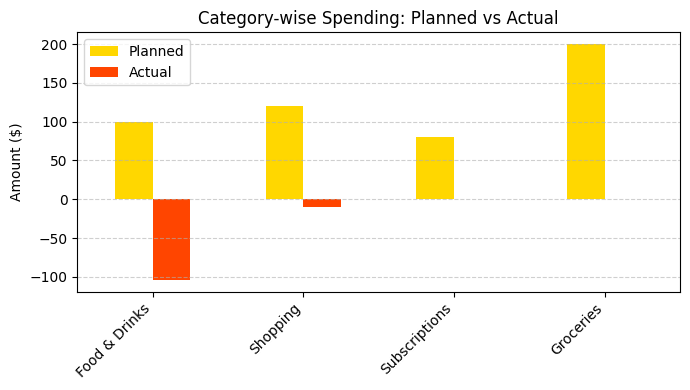

In [124]:
import matplotlib.pyplot as plt

# 1. Get total spending per category from monthly_summary
actual_spend = monthly_summary.groupby("category")["amount"].sum()

# 2. Use only categories the user specified in user_goals
goal_categories = user_goals["category_limits"].keys()

# 3. Build comparison DataFrame
comparison_df = pd.DataFrame({
    "Planned": pd.Series(user_goals["category_limits"]),
    "Actual": actual_spend
}).loc[goal_categories].fillna(0)

# 4. Plot it
comparison_df.plot(kind="bar", figsize=(7, 4), color=["gold", "orangered"])
plt.title("Category-wise Spending: Planned vs Actual")
plt.ylabel("Amount ($)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Budget planning

In [123]:
budget_prompt = """
Generate a monthly budget under $800 prioritizing Rent and Groceries, and limiting Dining/Subscriptions.
Return only JSON.
"""

response = model.generate_content(budget_prompt)
budget_plan = json.loads(response.text.replace("```json", "").replace("```", "").strip())
print(json.dumps(budget_plan, indent=2))

{
  "category": "Monthly Budget (Under $800)",
  "budget": 790,
  "items": [
    {
      "name": "Rent",
      "amount": 400,
      "notes": "Prioritized - Adjust based on your location/housing situation"
    },
    {
      "name": "Groceries",
      "amount": 200,
      "notes": "Prioritized -  Cook at home to save on dining out"
    },
    {
      "name": "Utilities",
      "amount": 50,
      "notes": "Electricity, water, gas - may vary based on location and usage"
    },
    {
      "name": "Transportation",
      "amount": 50,
      "notes": "Public transport, cycling, or gas/car maintenance"
    },
    {
      "name": "Phone",
      "amount": 30,
      "notes": "Prepaid or low-cost plan recommended"
    },
    {
      "name": "Internet",
      "amount": 30,
      "notes": "Consider low-cost options or sharing with roommates"
    },
    {
      "name": "Personal Care",
      "amount": 20,
      "notes": "Toiletries, hygiene products"
    },
    {
      "name": "Dining/Entertainmen